In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from urllib.parse import urlparse
import spacy

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, confusion_matrix, classification_report

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('./datasets/cleaned_comics_data.csv')

In [3]:
df.head()

,title,post,subreddit,up_votes,up_vote_ratio,clean_title,clean_post,clean_text,title_length,post_length,title_word_count,post_word_count,post_has_text
0,"weekly discussion thread: comics, tv, and more...",hey there honorary justice league members - it...,DCcomics,16,0.84,weekly discussion thread comics tv and more ap...,hey there honorary justice league members it ’...,weekly discussion thread comics tv and more ap...,98,4827.0,17,355.0,1
1,dead boy detectives megathread,# [***dead boy detectives***] (https://m.media...,DCcomics,12,0.80,dead boy detectives megathread,dead boy detectives \n\n time date april 25 20...,dead boy detectives megathread dead boy detect...,30,1957.0,4,132.0,1
2,[comic excerpt] tim realizes he's fallen in lo...,NaN,DCcomics,470,0.96,comic excerpt tim realizes he 's fallen in lov...,NaN,comic excerpt tim realizes he 's fallen in lov...,80,0.0,13,0.0,0
3,[comic excerpt] bros really thought they could...,NaN,DCcomics,65,0.90,comic excerpt bros really thought they could d...,NaN,comic excerpt bros really thought they could d...,119,0.0,20,0.0,0
4,"[discussion] it’s donna troy’s birthday, say s...",artist: https://www.tumblr.com/fatimajpeg/6998...,DCcomics,132,0.99,discussion it ’s donna troy ’s birthday say so...,artist,discussion it ’s donna troy ’s birthday say so...,69,86.0,10,2.0,1


### Make the Subreddit a numeric so Marvel = 1

In [4]:
df['subreddit'].value_counts()

subreddit
DCcomics    844
Marvel      831
Name: count, dtype: int64

In [5]:
df['subreddit'].replace( {'DCcomics' : 0, 'Marvel' : 1}, inplace = True )

In [6]:
df['subreddit'].value_counts()

subreddit
0    844
1    831
Name: count, dtype: int64

In [7]:
df['subreddit'].value_counts(normalize = True)

subreddit
0    0.503881
1    0.496119
Name: proportion, dtype: float64

### Create `X` and `y` and do train_test_split

In [8]:
X = df['clean_text']
y = df['subreddit']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 616, stratify = y)
    # Random state of 616 in honor of Marvel home universe
    # Even though it's fairly balanced, will still stratify

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1256,), (419,), (1256,), (419,))

#### Running a GridSearchCV over a Logistic Regression

In [11]:
pipe = Pipeline([
    ('tf', TfidfVectorizer() ),
    ('logr', LogisticRegression() )
])

In [12]:
pipe_params = {
    'tf__stop_words' : [None, 'english'],
    'tf__max_features' : [2000, 3000, 4000, 5000, 6000], 
    'tf__min_df' : [2, 4, 6],
    'tf__ngram_range' : [ (1,1), (1,2), (1,3) ], #Look for not just individual words but word patterns like "Dark Knight Rises", "Avengers Infinity War")
}

In [13]:
gs = GridSearchCV(pipe, pipe_params, n_jobs = -1)

In [14]:
gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('logr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'tf__max_features': [2000, 3000, 4000, 5000, 6000],
                         'tf__min_df': [2, 4, 6],
                         'tf__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'tf__stop_words': [None, 'english']})

In [15]:
#X_train_words = gs.fit(X_train, y_train)

In [16]:
#X_train_words

In [17]:
gs.best_score_

0.928346929741352

In [18]:
gs.best_params_

{'tf__max_features': 3000,
 'tf__min_df': 2,
 'tf__ngram_range': (1, 1),
 'tf__stop_words': 'english'}

In [19]:
gs.best_estimator_.named_steps

{'tf': TfidfVectorizer(max_features=3000, min_df=2, stop_words='english'),
 'logr': LogisticRegression()}

In [20]:
gs.best_estimator_.named_steps.tf.get_feature_names_out()

array(['10', '100', '1064', ..., 'zero', 'zone', 'zucco'], dtype=object)

In [21]:
type(gs.best_estimator_.named_steps.tf.get_feature_names_out())

numpy.ndarray

In [22]:
gs.score(X_train, y_train), gs.score(X_test, y_test)

(0.9872611464968153, 0.9522673031026253)

### This model can predict the reddit thread with 95.2% accuracy

In [23]:
gs.predict_proba(X_test) #The probabilities that it is in each class

array([[0.76695081, 0.23304919],
       [0.38355229, 0.61644771],
       [0.20818366, 0.79181634],
       [0.18780699, 0.81219301],
       [0.60032556, 0.39967444],
       [0.22779538, 0.77220462],
       [0.43780228, 0.56219772],
       [0.35461929, 0.64538071],
       [0.18626056, 0.81373944],
       [0.46611073, 0.53388927],
       [0.9047232 , 0.0952768 ],
       [0.31360787, 0.68639213],
       [0.87529579, 0.12470421],
       [0.77894579, 0.22105421],
       [0.05439104, 0.94560896],
       [0.85004761, 0.14995239],
       [0.25031997, 0.74968003],
       [0.18864115, 0.81135885],
       [0.83584018, 0.16415982],
       [0.24628111, 0.75371889],
       [0.74388932, 0.25611068],
       [0.62946308, 0.37053692],
       [0.89310305, 0.10689695],
       [0.38929186, 0.61070814],
       [0.32834517, 0.67165483],
       [0.65861651, 0.34138349],
       [0.15851541, 0.84148459],
       [0.38685871, 0.61314129],
       [0.28943565, 0.71056435],
       [0.88864235, 0.11135765],
       [0.

In [24]:
#The probabilities that each item is in class 0 (DC) or 1 (Marvel)
probabilities = pd.DataFrame(gs.predict_proba(X_test), index = X_test.index)
probabilities

,0,1
301,0.766951,0.233049
1361,0.383552,0.616448
1655,0.208184,0.791816
867,0.187807,0.812193
766,0.600326,0.399674
...,...,...
1580,0.334712,0.665288
174,0.754961,0.245039
1491,0.190943,0.809057
952,0.201835,0.798165


In [25]:
pred = gs.predict(X_test)

In [26]:
pred.shape

(419,)

In [27]:
# The predict probas for the features from the model
gs.predict_proba(gs.best_estimator_.named_steps.tf.get_feature_names_out() )

array([[0.38302521, 0.61697479],
       [0.4120195 , 0.5879805 ],
       [0.44964793, 0.55035207],
       ...,
       [0.38260816, 0.61739184],
       [0.45009315, 0.54990685],
       [0.3900047 , 0.6099953 ]])

In [28]:
type(gs.predict_proba(gs.best_estimator_.named_steps.tf.get_feature_names_out() ) )

numpy.ndarray

In [29]:
#Convert the predict probas into a dataframe
probabilities_df = pd.DataFrame( gs.predict_proba(gs.best_estimator_.named_steps.tf.get_feature_names_out() ), columns = ['dc_probability', 'marvel_probability'])
probabilities_df

,dc_probability,marvel_probability
0,0.383025,0.616975
1,0.412020,0.587980
2,0.449648,0.550352
3,0.451203,0.548797
4,0.493873,0.506127
...,...,...
2995,0.421760,0.578240
2996,0.346331,0.653669
2997,0.382608,0.617392
2998,0.450093,0.549907


In [30]:
feature_words = pd.DataFrame( gs.best_estimator_.named_steps.tf.get_feature_names_out(), columns = ['features'] )
feature_words

,features
0,10
1,100
2,1064
3,1067
4,1084
...,...
2995,zdarsky
2996,zemo
2997,zero
2998,zone


In [31]:
word_probabilities = feature_words.join(probabilities_df)
word_probabilities.sort_values('marvel_probability')

,features,dc_probability,marvel_probability
724,dc,0.980858,0.019142
323,batman,0.962265,0.037735
244,artwork,0.947793,0.052207
2599,superman,0.938042,0.061958
804,discussion,0.915775,0.084225
...,...,...,...
730,deadpool,0.078002,0.921998
2948,wolverine,0.068999,0.931001
2500,spider,0.047669,0.952331
1751,men,0.030574,0.969426


In [67]:
#All the words where the DC Probability is above 75%
most_dc_words = word_probabilities[word_probabilities['dc_probability'] > 0.75].sort_values('marvel_probability')
most_dc_words

,features,dc_probability,marvel_probability
724,dc,0.980858,0.019142
323,batman,0.962265,0.037735
244,artwork,0.947793,0.052207
2599,superman,0.938042,0.061958
804,discussion,0.915775,0.084225
939,excerpt,0.913640,0.086360
978,fan,0.865135,0.134865
586,comic,0.837111,0.162889
687,crisis,0.777657,0.222343
1462,joker,0.767096,0.232904


In [33]:
most_dc_words.shape

(11, 3)

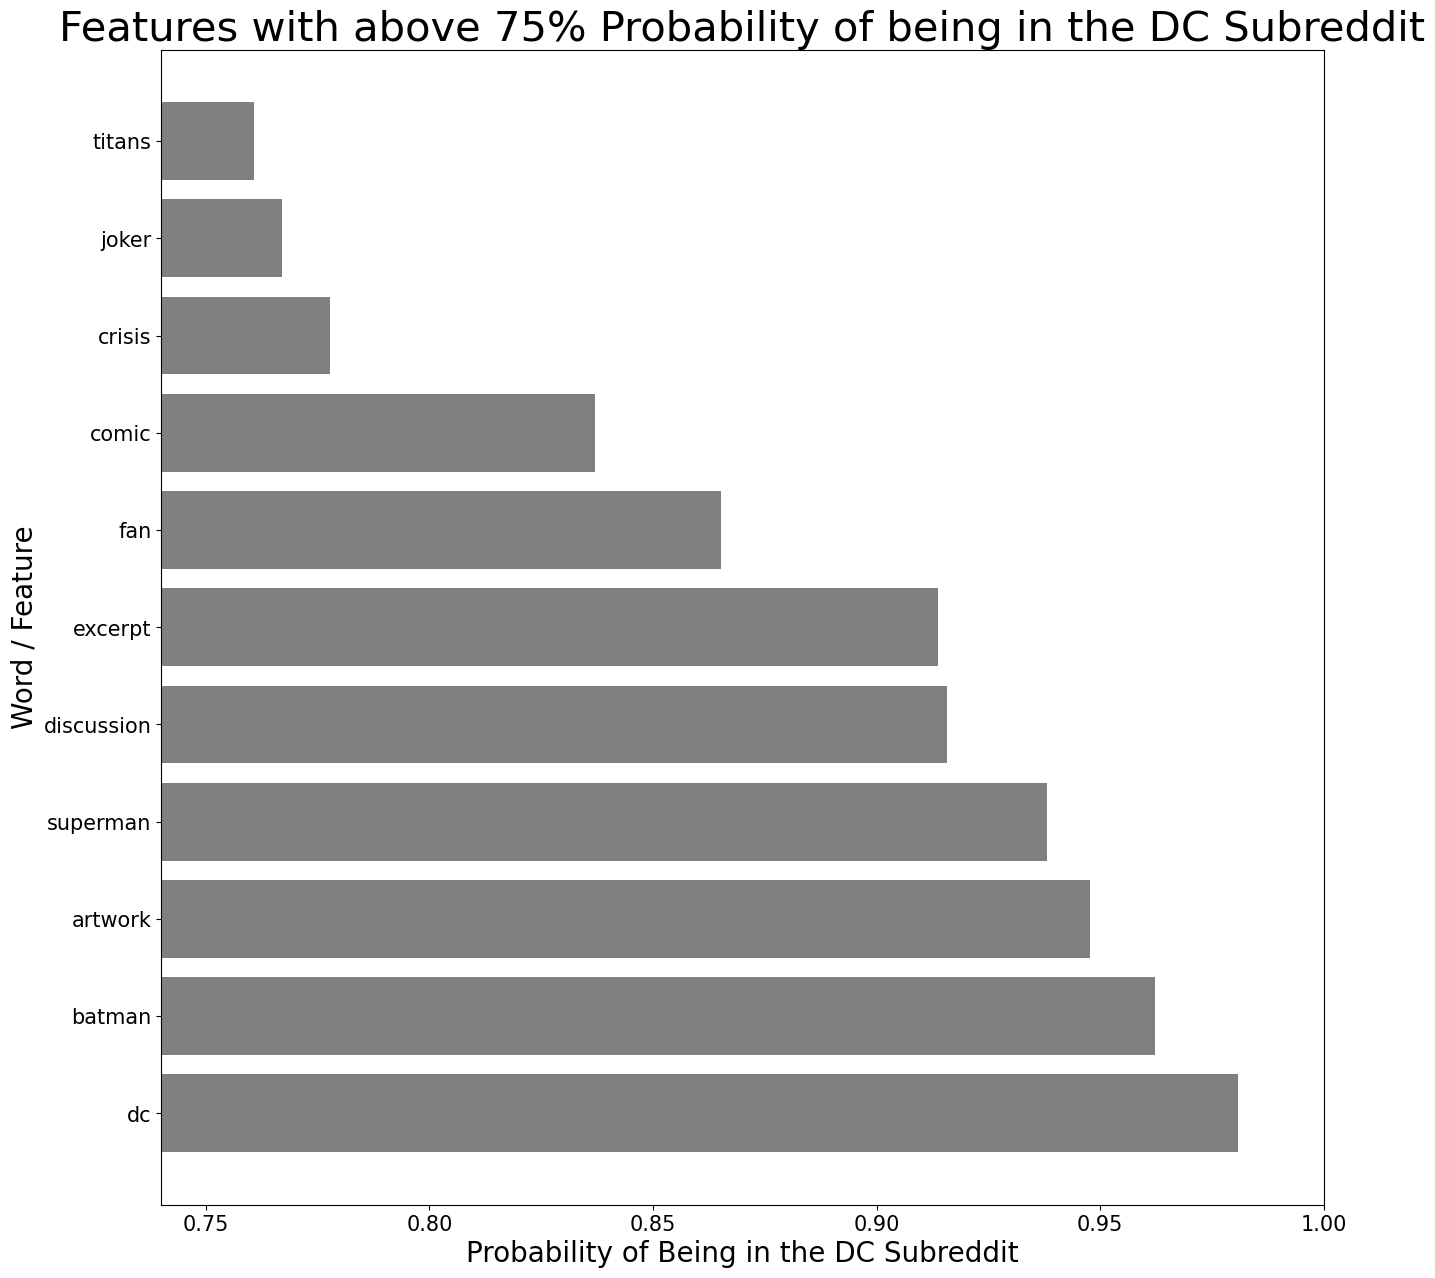

In [73]:
plt.figure(figsize = (15,15))

ax = plt.gca()

plt.barh(most_dc_words['features'],
         most_dc_words['dc_probability'],
        color = 'grey');

ax.set_xlim([0.74, 1]) #https://stackoverflow.com/questions/3777861/how-to-set-the-axis-limits

plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel('Probability of Being in the DC Subreddit', size = 20)
plt.ylabel('Word / Feature', size = 20)
plt.title('Features with above 75% Probability of being in the DC Subreddit', size = 30)

plt.savefig('../project-3/images/dc_feature_probability');

In [35]:
# Features with above 75% probability of being in the Marvel Subreddit
most_marvel_words = word_probabilities[word_probabilities['marvel_probability'] > 0.75].sort_values('marvel_probability')
most_marvel_words

,features,dc_probability,marvel_probability
2981,xmen,0.249938,0.750062
829,dr,0.248886,0.751114
1934,opinion,0.247576,0.752424
722,day,0.245945,0.754055
984,fantastic,0.245324,0.754676
833,drawing,0.243667,0.756333
2093,punisher,0.241360,0.758640
1012,ff,0.235778,0.764222
979,fanart,0.232403,0.767597
1423,iron,0.227410,0.772590


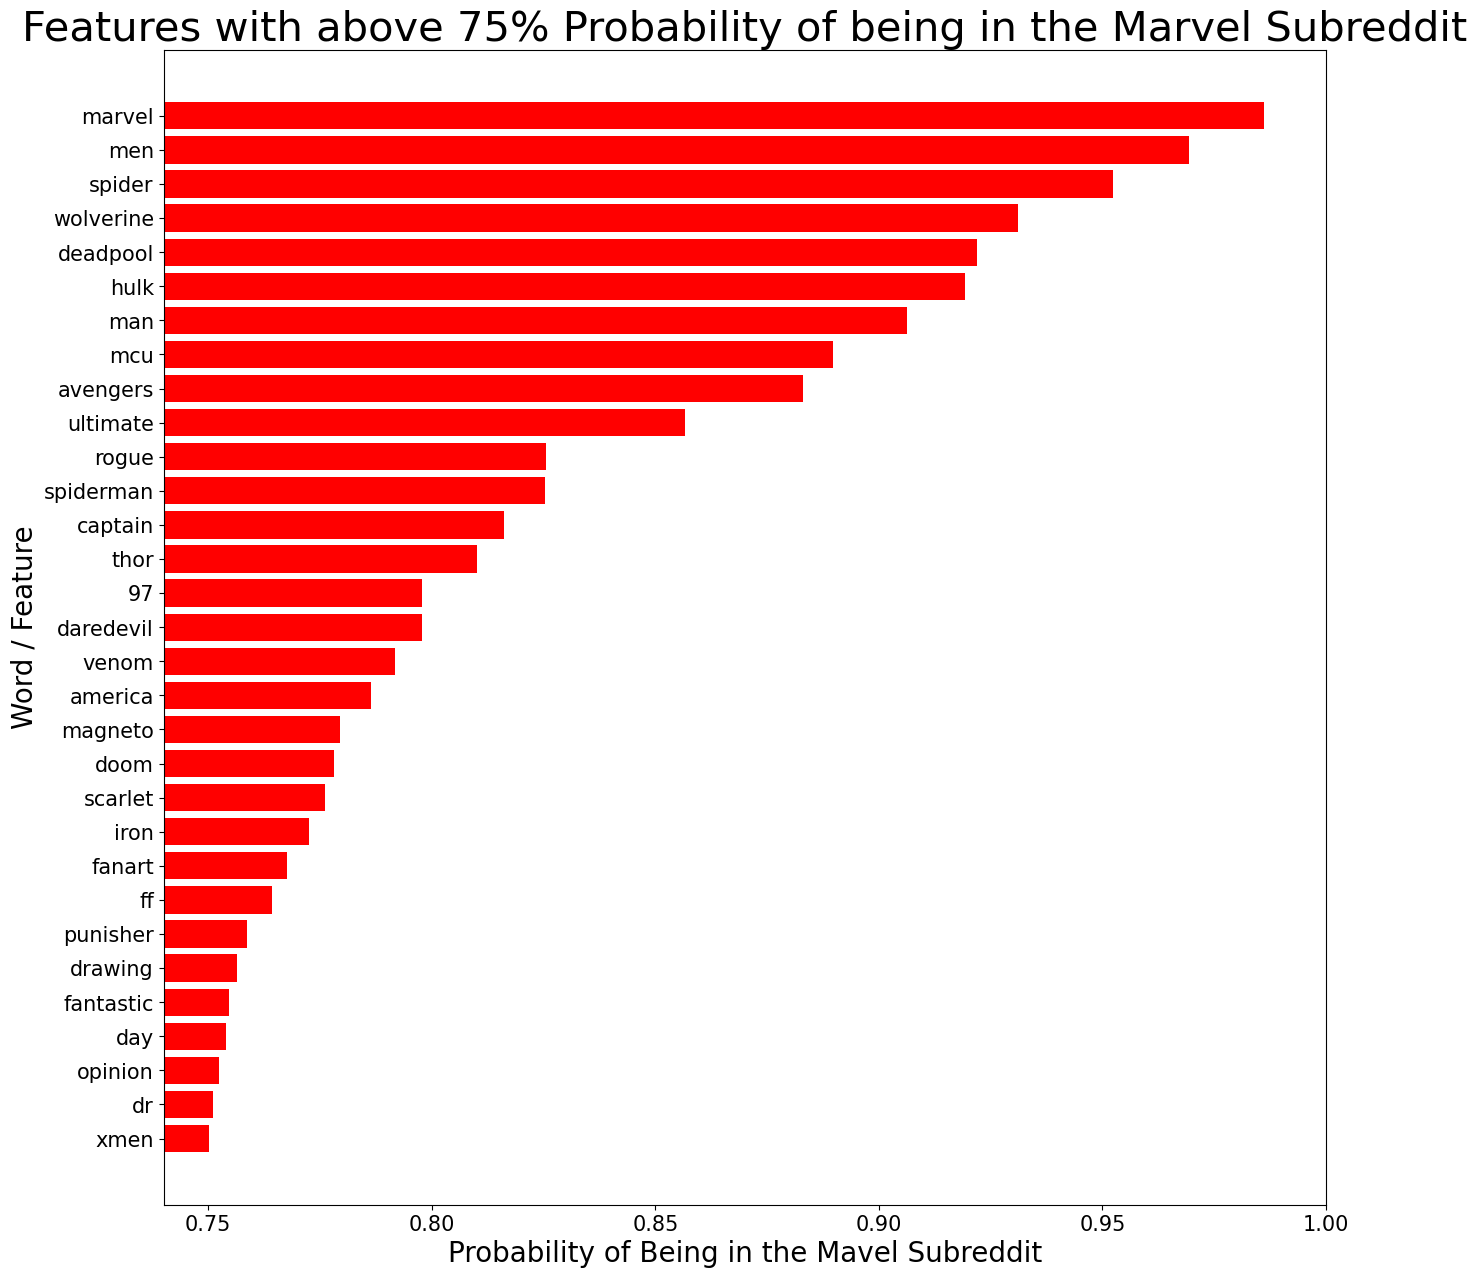

In [62]:
plt.figure(figsize = (15,15))

ax = plt.gca()

plt.barh(most_marvel_words['features'],
         most_marvel_words['marvel_probability'],
        color = 'red');

ax.set_xlim([0.74, 1]) #https://stackoverflow.com/questions/3777861/how-to-set-the-axis-limits

plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel('Probability of Being in the Mavel Subreddit', size = 20)
plt.ylabel('Word / Feature', size = 20)
plt.title('Features with above 75% Probability of being in the Marvel Subreddit', size = 30)

plt.savefig('../project-3/images/marvel_feature_probability');

In [37]:
true_neg, false_pos, false_neg, true_pos = confusion_matrix(y_test, pred).ravel()

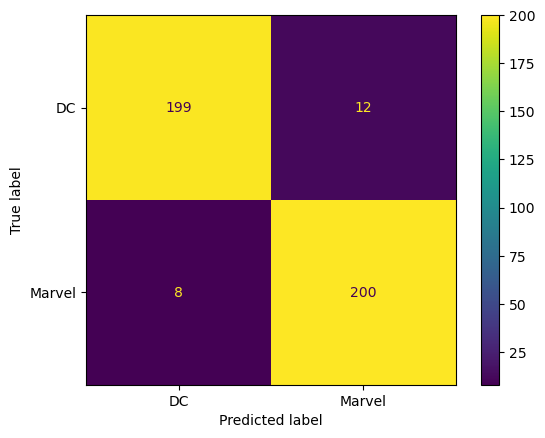

In [58]:
ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test, 
                                      display_labels = ['DC', 'Marvel'], #Adding labels to identify which company is which
                                      );

plt.savefig('../project-3/images/gs_tfidf_logreg_confusion_matrix.png', dpi = 192)

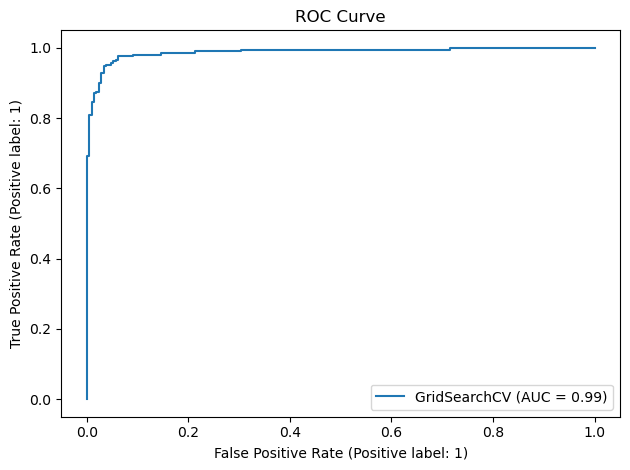

In [61]:
RocCurveDisplay.from_estimator(gs, X_test, y_test);

plt.title('ROC Curve')

plt.tight_layout()

plt.savefig('../project-3/images/gs_tfidf_roc_curve.png', dpi = 192);

In [40]:
gs.best_estimator_.named_steps.tf.get_feature_names_out()

array(['10', '100', '1064', ..., 'zero', 'zone', 'zucco'], dtype=object)

In [41]:
# These are the 20 words/phrases that are common in one document (post) but not common in the rest of the corpus (all the other posts)
pd.DataFrame(index = gs.best_estimator_.named_steps.tf.get_feature_names_out(),
             data = gs.best_estimator_.named_steps.tf.idf_,
             columns = ['idf_score']).sort_values(by = 'idf_score', ascending = False).head(50)

,idf_score
zucco,7.037871
doomwar,7.037871
omg,7.037871
dragon,7.037871
omnipotent,7.037871
opening,7.037871
doubt,7.037871
opens,7.037871
opposite,7.037871
oldest,7.037871


In [42]:
#These are common words across all documents (posts)
pd.DataFrame(index = gs.best_estimator_.named_steps.tf.get_feature_names_out(),
             data = gs.best_estimator_.named_steps.tf.idf_,
             columns = ['idf_score']).sort_values(by = 'idf_score', ascending = False).tail(20)

,idf_score
did,3.625624
character,3.614695
fan,3.603884
does,3.561772
good,3.541363
superman,3.463654
ve,3.454352
read,3.409095
new,3.374309
art,3.348991


In [43]:
# pd.DataFrame(index = gs.best_estimator_.named_steps.cvec.get_feature_names_out(), data = gs.idf_, columns = ['Freq Score'])

In [44]:
#The text it is predicting incorrectly: https://stackoverflow.com/questions/71928062/identifying-misclassified-raw-data-in-after-machine-learning-in-python
X_test[y_test != pred]

685     what are your thoughts on the start of house o...
119     help with dc characters i was always more of a...
586     how many lobo compendium will there be first o...
1379                                   g.o.d.s 7 preview 
246     the flash series i realize why i stop watching...
366     other marvel taking a jab at dc comics for ide...
538     james tynion iv returns to nice house on the l...
1628    is what modern spider- man run is worth readin...
725     i prefer to read clark and bruce as supporting...
1654    is there any difference between livewires trad...
1224                   who is your favorite team and why 
214            \n josh keaton 's web warriors 🕸 ️ \n \n\n
1505                                  what comic is this 
1066    anyone know which version of galactus this is ...
342     merchandise static shock figure collection i '...
727     worlds first fully rexine built dr fate cospla...
127     form and function is there an in canon explana...
1604    who 's

In [45]:
incorrect = pd.DataFrame(X_test[y_test != pred])
incorrect

,clean_text
685,what are your thoughts on the start of house o...
119,help with dc characters i was always more of a...
586,how many lobo compendium will there be first o...
1379,g.o.d.s 7 preview
246,the flash series i realize why i stop watching...
366,other marvel taking a jab at dc comics for ide...
538,james tynion iv returns to nice house on the l...
1628,is what modern spider- man run is worth readin...
725,i prefer to read clark and bruce as supporting...
1654,is there any difference between livewires trad...


### Most of the ones its getting wrong are ones the model isn't confident in.

Only 2 of the 20 it gets wrong does it think there's more than a two-thirds chance it is one subreddit or the other

In [46]:
pd.set_option('display.max_colwidth', 500)
incorrect_df = incorrect.join([df['subreddit'], probabilities]).sort_values(1)
# Renaming columns for output
incorrect_df.rename(columns = {0 : 'DC Probability', 
                               1 : 'Marvel Probability',
                              'clean_text' : 'Clean Text',
                              'subreddit' : 'Subreddit'}, inplace = True)

In [47]:
len(incorrect_df)

20

In [57]:
incorrect_df['Subreddit'].replace( {0 : 'DC', 1 : 'Marvel'}, inplace = True )
incorrect_df[['Clean Text', 'Subreddit', 'Marvel Probability']]

,Clean Text,Subreddit,Marvel Probability
1505,what comic is this,Marvel,0.162889
1604,who 's autograph is this found a french black panther comic \n does anyone know the signature is on the cover,Marvel,0.316420
1023,took a stab at making my own action figure comic book cover,Marvel,0.366051
1379,g.o.d.s 7 preview,Marvel,0.402259
1628,is what modern spider- man run is worth reading i was wanting to read nick spencer ’s run of sm but heard he messes up his story or it ’s really bad etc and just wondering if there ’s a better recent current ongoing sm comic that i should read \n,Marvel,0.445635
1224,who is your favorite team and why,Marvel,0.495747
1066,anyone know which version of galactus this is curious cause i ’ve never seen this version before anyone know anything about him or know his name,Marvel,0.498882
1654,is there any difference between livewires trades with blue or red spines i 've been interested in picking up the livewires trade but i always see two a blue and a red spine \n\n i just wanted to know if there 's a difference and what it is i wanna make sure i 'm not gon na end up getting a black and white reprint or a smaller copy or something,Marvel,0.499925
725,i prefer to read clark and bruce as supporting or supporting main rather then the focus i enjoy them both as a supporting characters they 're fun to read but i do as much enjoy picking up a comic when it is their story only about them \n\n granted i 've read very few of them as main so i 'm happy for some recs to change my mind,DC,0.500924
119,help with dc characters i was always more of a marvel guy when it came to comics i watched dc movies but have read any dc comics other then the batman prey storyline i some recommendations for characters you think i would like some of my favorite characters from marvel are wolverine punisher ghost rider and spider man another one of my favorite super hero is not from marvel or dc he is the crow if you know you know any characters recommendations based on some of my favorites from other things,DC,0.514172
